---
title: Validating High Correlation Genes from Huang et al.
author: Sabrina Mi
date: 10/18/2023
---

[Huang et al.](https://www.biorxiv.org/content/10.1101/2023.06.30.547100v1.full.pdf) recorded high cross-population correlation for SLFN5 (Ensembl: ENSG00000166750) from Enformer (CAGE:LCL) on GEUVADIS individuals. We will run the same test with Borzoi's stranded CAGE tracks and GTEx RNA-seq.

![Huang et al. Figure](SLFN5.png)

In [4]:
import pandas as pd
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t", index_col="ensembl_gene_id")
hg38_annot.loc['ENSG00000166750']

external_gene_name             SLFN5
chromosome_name                   17
transcription_start_site    35243072
transcript_start            35243072
transcript_end              35273655
Name: ENSG00000166750, dtype: object

```
module load conda
conda activate borzoi
cd /home/s1mi/Github/deep-learning-in-genomics/posts/2023-10-18-borzoi-personalized-on-Huang-et-al-high-performance-gene

export LD_LIBRARY_PATH=/soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:$LD_LIBRARY_PATH

echo $LD_LIBRARY_PATH

python3 personalized_prediction.py \
--intervals_file intervals.txt \
--fasta_file /home/s1mi/borzoi_tutorial/hg38.fa \
--vcf_dir /grand/TFXcan/imlab/data/1000G/vcf_snps_only \
--individuals_file individuals.txt \
--model_dir /home/s1mi/borzoi_tutorial \
--output_dir /grand/TFXcan/imlab/users/sabrina/redo-borzoi-personalized-test

```

In [5]:
import pandas as pd
import numpy as np
import os
import h5py
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t", index_col="ensembl_gene_id")
seq_len = 524288
seq_out_len = 523264
gene = "ENSG00000166750"
predictions_dir = "/grand/TFXcan/imlab/users/sabrina/redo-borzoi-personalized-test"
with open("individuals.txt", "r") as f:
    individuals = f.read().splitlines()

In [25]:
CAGE_predictions = []
for individual in individuals:
    predictions_file = os.path.join(predictions_dir, individual, 'chr17_35243072_35243072_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo_1 = hf['haplotype1'][:, 8174:8178, [870,871]]
        haplo_2 = hf['haplotype2'][:, 8174:8178, [870,871]]
        CAGE_1 = np.mean(haplo_1)
        CAGE_2 = np.mean(haplo_2)
        CAGE_predictions.append((CAGE_1 + CAGE_2) / 2)

In [7]:
geuvadis_gex = pd.read_csv("/lus/grand/projects/TFXcan/imlab/data/1000G/expression/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz", sep="\t")
geuvadis_gex['TargetID'] = geuvadis_gex['TargetID'].apply(lambda gene: gene.split('.')[0])
geuvadis_gex.set_index('TargetID', inplace=True)
observed = pd.to_numeric(geuvadis_gex.loc[gene][individuals])

In [26]:
gex_df = pd.DataFrame({'Predicted': CAGE_predictions, 'Observed': observed}, index = individuals)
gex_df.corr(method="spearman")

,Predicted,Observed
Predicted,1.000000,0.158283
Observed,0.158283,1.000000


In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

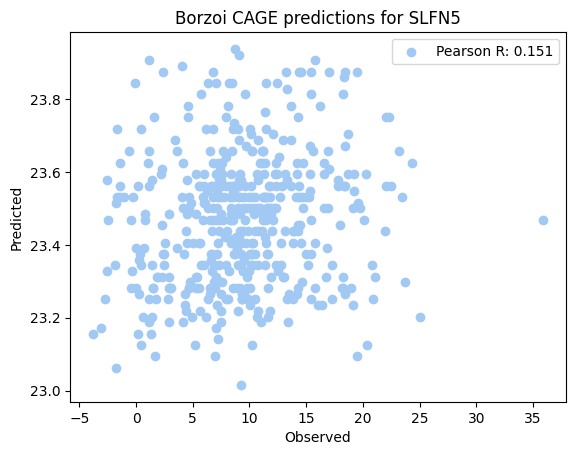

In [29]:
colors = sns.color_palette("pastel")
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Pearson R: {corr:.3f}")

# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Borzoi CAGE predictions for SLFN5")

# Show the plot
plt.legend()
plt.show()

## Positive Strand Only

In [23]:
stranded_CAGE_predictions = []
for individual in individuals:
    predictions_file = os.path.join(predictions_dir, individual, 'chr17_35243072_35243072_predictions.h5')
    with h5py.File(predictions_file, "r") as hf:
        haplo_1 = hf['haplotype1'][:, 8174:8178, 870]
        haplo_2 = hf['haplotype2'][:, 8174:8178, 870]
        CAGE_1 = np.mean(haplo_1)
        CAGE_2 = np.mean(haplo_2)
        stranded_CAGE_predictions.append((CAGE_1 + CAGE_2) / 2)

In [28]:
gex_df['Predicted+'] = stranded_CAGE_predictions
gex_df[['Observed', 'Predicted', 'Predicted+']].corr(method="spearman")

,Observed,Predicted,Predicted+
Observed,1.000000,0.158283,0.160137
Predicted,0.158283,1.000000,0.997363
Predicted+,0.160137,0.997363,1.000000


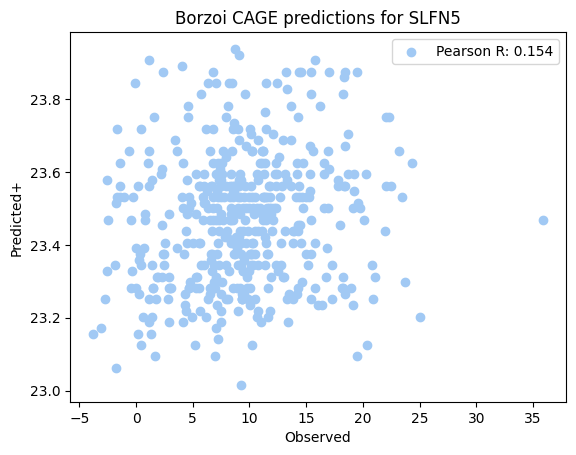

In [30]:
colors = sns.color_palette("pastel")
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted+'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Pearson R: {corr:.3f}")

# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted+")
plt.title("Borzoi CAGE predictions for SLFN5")

# Show the plot
plt.legend()
plt.show()